In [3]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid') # TODO: what did this do?
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
# on error `pip install ipython-sql`
#uncomment for remote
#pgport=3333
pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [4]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


Count number of uploaded APK files

In [33]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select
    (select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%') as apk_count,
    (select count(*) from apks) as blob_count, 
    (select count(*) from inputs) as input_count, 
    (select count(*) from jobs) as job_count, 
    (select count(*) from resultdata) as result_data_count, 
    (select count(*) from results) as result_count

1 rows affected.


apk_count,blob_count,input_count,job_count,result_data_count,result_count
56,58,1,1371,4,4


Print jobs and statuses

In [55]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs) as Total_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%an implementation is missing%') as unimplemented,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%no libz3java in java.library.path%') as path_exception,
    (select count(id) from jobs where stderr like '%Failed to parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred location%') as possible_cg_unsound,
    (select count(id) from jobs where stderr like '%OutOfMemory%') as memory
 

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


completed_jobs,paused_jobs,total_jobs,acquired_jobs,body_exception,unimplemented,exception,path_exception,refl_exception,worker_failure,possible_cg_unsound,memory
633,0,1371,7,0,0,152,0,0,0,0,152


In [63]:
%%sql
select owner,count(*) from jobs where status ='completed' group by owner;

 * postgresql://postgres@localhost:5433/postgres
2 rows affected.


owner,count
Linux Loaner 5.19.0-31-generic #32-Ubuntu SMP PREEMPT_DYNAMIC Fri Jan 20 15:20:08 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux,638
Linux Loki 5.15.0-60-generic #66-Ubuntu SMP Fri Jan 20 14:29:49 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux,39


In [83]:
%%sql
select cast(jobs.config::json->'apkPath' as varchar) as apk, cast(jobs.config::json->'initialQuery' as varchar) as iq from jobs inner join results on jobs.id=results.jobid 
where cast(jobs.config::json->'apkPath' as varchar) like '%ch.blinkenlights.android.vanilla_12200%' and
cast(jobs.config::json->'initialQuery' as varchar) like '%3%'
limit 2;

 * postgresql://postgres@localhost:5433/postgres
2 rows affected.


apk,iq
"""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""","[{""methodName"":""android.view.View onCreateView(android.view.LayoutInflater,android.view.ViewGroup,android.os.Bundle)"",""line"":263,""t"":""ReceiverNonNull"",""matcher"":""android.content.res.Resources$Theme getTheme()"",""className"":""ch.blinkenlights.android.vanilla.PreferencesActivity$AboutFragment""}]"
"""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""","[{""methodName"":""void onCreate(android.os.Bundle)"",""line"":163,""t"":""ReceiverNonNull"",""matcher"":""java.lang.String getPackageName()"",""className"":""ch.blinkenlights.android.vanilla.PreferencesActivity$EqualizerFragment""}]"


In [72]:
%%sql
select id,count(*) from jobs group by id order by count(*) desc limit 5 

 * postgresql://postgres@localhost:5433/postgres
5 rows affected.


id,count
125411,1
124592,1
125271,1
124177,1
125360,1


In [53]:
qry = %sql select qry from results limit 1;
print(qry[0][0])

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.
{"methodName":"void onSharedPreferenceChanged(android.content.SharedPreferences,java.lang.String)","line":96,"t":"ReceiverNonNull","matcher":"android.content.ComponentName startService(android.content.Intent)","className":"net.justdave.nwsweatheralertswidget.SettingsFragment"}


In [54]:
# find exceptions
#%%sql 
#select replace(cast(stderr as varchar),'$','\$') from jobs where stderr like '%Exception%' limit 1;
outs = %sql select stderr,config from jobs where stderr like '%Exception%' and stderr not like '%OutOfMemory%' order by random() limit 1;
for out in outs:
    print(out[1])
    print(out[0])


 * postgresql://postgres@localhost:5433/postgres
0 rows affected.


In [ ]:
%%sql
select cast(results.result::json->'summary' as varchar) as summary, cast(jobs.config::json->'apkPath' as varchar) as benchmark,count(*) from results inner join jobs on jobs.id=results.jobid group by summary,benchmark order by benchmark,summary desc

In [ ]:
# find failed job
failed = %sql select jobs.config,results.qry from jobs inner join results on jobs.id=results.jobid where cast(results.result::json->'summary' as varchar) like '%Unknown, no more axioms%'

if len(failed) > 0:
    print(failed[0][0])


Get failing apks

In [ ]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception%' group by cast(config::json->'apkPath' as text) ;

In [ ]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

In [ ]:
%%sql
select count(*),status from jobs group by status;

In [ ]:
%%sql 
select cast(result::json->'summary' as varchar) as summary, cast(result::json->'maxPathCh' as varchar) as ch,count(*),avg(querytime),max(querytime) from results group by summary,ch order by summary,ch;

In [ ]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as category, 
    count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles'),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')

In [ ]:
res = %sql select distinct regexp_substr(cast(jobs.config::json->'apkPath' as varchar), '[a-zA-Z]*\.[a-zA-Z]*') as benchmark from results inner join jobs on results.jobid=jobs.id group by cast(jobs.config::json->'apkPath' as varchar)

len(res)

In [ ]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), '[a-zA-Z]*\.[a-zA-Z]*') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as isDismiss, 
    cast(results.result::json->'summary' as varchar) as summary, count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by cast(jobs.config::json->'apkPath' as varchar),cast(results.result::json->'summary' as varchar),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')


In [ ]:
%%sql
select cast(result::json->'summary' as varchar) as summary, count(*) from results, group by cast(result::json->'summary' as varchar)

In [ ]:
%%sql
select id from results where cast(results.result::json->'summary' as varchar) like '%Witnessed%'

In [ ]:
cfg = %sql select jobs.config from results inner join jobs on results.jobid=jobs.id where cast(results.result::json->'summary' as varchar) like '%Witnessed%' limit 1;
cfg[0][0]

In [ ]:
%%sql
select id,cast(result::json->'summary' as varchar) as summary,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results order by random() limit 5;

Check result consistency
========================

In [ ]:
%%sql -- get workers with acquired jobs
select owner,count(*) from jobs where status='acquired' group by owner;

In [ ]:
%%sql -- Find completed jobs where no results exist and no error occurred
select jobs.id from jobs where jobs.id not in (select results.jobid from results) and jobs.status = 'completed' and jobs.stderr not like '%Exception%';

In [ ]:
%%sql -- Find new/paused jobs with results
select jobs.id from jobs where jobs.id in (select results.jobid from results) and (jobs.status = 'paused' or jobs.status = 'new');

In [ ]:
%%sql -- check that each location/qry pair only has one result (should detect duplicat runs)
select count(*),qry,loc as num from results group by qry,loc order by count(*) desc limit 1;

Triage witness results
----------------------

In [ ]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Witnessed%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWit.csv')

In [ ]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Itimeout%' and cast(result::json->'maxPathCh' as varchar) like '%MultiCallback%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWitMultiTimeout.csv')

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'line'->'str' as varchar),'$','\$') from results where id = 40;

Triage proven results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where cast(result::json->'summary' as varchar) like '%Proven%' order by random() limit 10;

Triage unreachable results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
            from results where cast(result::json->'summary' as varchar) like '%Unreachable%' 
            order by random() limit 15;

In [ ]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 15037;

In [ ]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

In [ ]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

Runtime Stats
=============

 * postgresql://postgres@localhost:5433/postgres
597 rows affected.


Text(0.5, 0, 'time (hrs)')

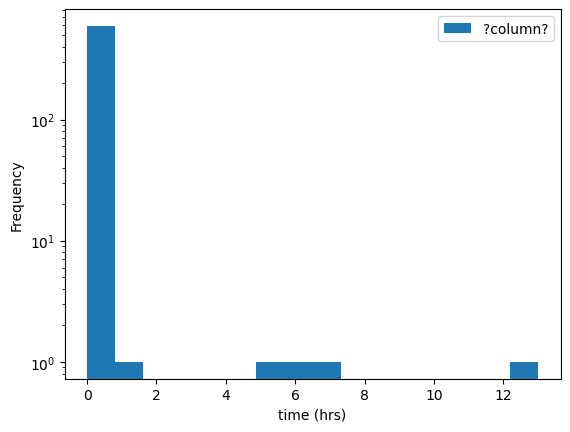

In [56]:
queryTime = %sql select querytime/60/60 from results;
tplt = queryTime.DataFrame().plot.hist(bins=16)
tplt.set_yscale('log')
# tplt.set_xscale('log')
tplt.set_xlabel('time (hrs)')
# split this into proven and witnessed

In [ ]:
%%sql
select 

In [62]:
cfg = %sql select jobs.config from results join jobs on jobs.id = results.jobid where querytime > 6*60*60 limit 1;
if len(cfg) > 0:
    print(cfg[0][0])

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.
{"apkPath":"${baseDir}/fdroid/com.fsck.k9/6.503/apk/com.fsck.k9_35003.apk","outFolder":["${baseDirOut}/com.fsck.k9"],"specSet":"{\"specs\":[],\"disallow\":[{\"univQuant\":[{\"$type\":\"edu.colorado.plv.bounder.symbolicexecutor.state.NamedPureVar\",\"n\":\"t\"}],\"existQuant\":[],\"pred\":{\"$type\":\"edu.colorado.plv.bounder.lifestate.LifeState.OAbsMsg\",\"mt\":{\"$type\":\"edu.colorado.plv.bounder.ir.CIExit\"},\"signatures\":{\"$type\":\"edu.colorado.plv.bounder.lifestate.LifeState.SubClassMatcher\",\"baseSubtypeOf\":[\"android.os.AsyncTask\"],\"signatureMatcher\":\".*AsyncTask execute\\\\(.*\\\\)\",\"ident\":\"AsyncTask_execute\"},\"lsVars\":[{\"$type\":\"edu.colorado.plv.bounder.symbolicexecutor.state.TopVal\"},{\"$type\":\"edu.colorado.plv.bounder.symbolicexecutor.state.NamedPureVar\",\"n\":\"t\"}]},\"target\":{\"$type\":\"edu.colorado.plv.bounder.lifestate.LifeState.OAbsMsg\",\"mt\":{\"$type\":\"edu.colorado.plv.bou

In [57]:
%%sql -- which apps cause runtimes over 2 hours?
select jobs.id, results.querytime, jobs.config::json->'apkPath' from results inner join jobs on jobs.id=results.jobid where results.querytime > 7200 order by results.querytime desc limit 200;

 * postgresql://postgres@localhost:5433/postgres
4 rows affected.


id,querytime,?column?
124324,48113,${baseDir}/fdroid/be.digitalia.fosdem/2.1.1/apk/be.digitalia.fosdem_1900211.apk
125157,26137,${baseDir}/fdroid/com.fsck.k9/6.503/apk/com.fsck.k9_35003.apk
124178,23974,${baseDir}/fdroid/com.fsck.k9/6.503/apk/com.fsck.k9_35003.apk
124871,21265,${baseDir}/fdroid/com.fsck.k9/6.503/apk/com.fsck.k9_35003.apk


 * postgresql://postgres@localhost:5433/postgres
633 rows affected.


Text(0.5, 0, 'time (min)')

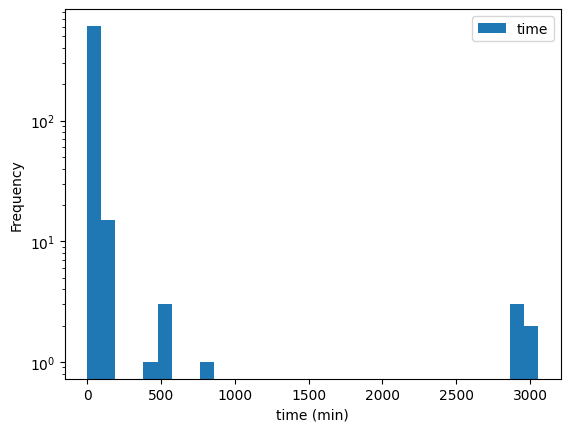

In [58]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:5433/postgres
100 rows affected.


/tmp/ipykernel_1540447/1841651425.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')


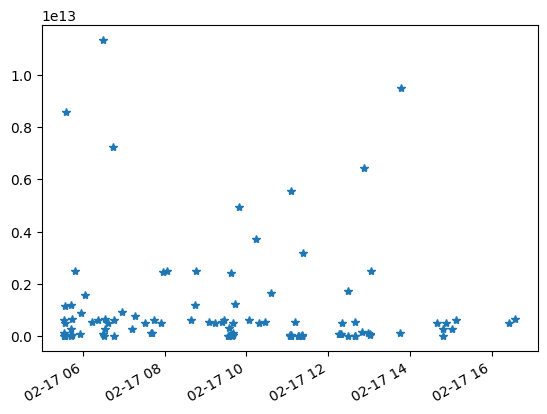

In [274]:
# Plot job time trend
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [142]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


sum
0:06:42.881000


In [143]:
%%sql
select avg(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


avg
0:03:21.440500


In [144]:
%%sql
select avg(querytime) from results;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


avg
13.2500000000000000


In [145]:
%%sql
select now() - min(started) from jobs;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


?column?
0:08:50.506825


Size of postgres data
=====================

In [ ]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

Inspection of exceptions
========================

In [ ]:
%%sql
select id,config::json->'apkPath',replace(stderr,'$','\$') from jobs where stderr like '%Exception%';

In [ ]:
#count of total results
%sql select count(*) as Total_locations_computed from results